In [91]:
import os
import h5py
import numpy as np
import cv2
from kymatio import Scattering2D
from PIL import Image
import matplotlib.pyplot as plt
#from sewar.full_ref import mse, rmse, psnr, uqi, ssim, ergas, scc, rase, sam, msssim, vifp
from astropy.cosmology import Planck15 as cosmo
import scipy
from scipy.ndimage import gaussian_filter1d

try:
    xrange(1)
except NameError:
    xrange = range

In [92]:
sim_res= 100

def get_mean_flux_scale(tau, desired_mean_flux, nbins, tol):
    newscale =1
    scale=0
    while np.abs(newscale-scale) > (tol*newscale):
        
        scale= newscale
        mean_flux =0
        tau_mean_flux =0
        nbins_used=0
        tau_mean=[]
        for i in range(0, 32000):
            tau_mean.append(np.mean(tau[i]))
        
       
        for i in range(0, nbins):
            temp= np.exp(-scale*tau_mean[i])
            mean_flux= mean_flux+temp
            tau_mean_flux = tau_mean_flux+temp*tau_mean[i]
            nbins_used=nbins_used+1
        
        newscale=scale+(mean_flux- desired_mean_flux * nbins_used)/tau_mean_flux

        if newscale <= 0:
            newscale=1e-10
            
    return newscale

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def _powerspectrum(inarray, axis=-1):
    """Compute the power spectrum of the input using np.fft"""
    rfftd = np.fft.rfft(inarray, axis=axis)
    # Want P(k)= F(k).re*F(k).re+F(k).im*F(k).im
    power = np.abs(rfftd)**2
    #Normalise the FFT so it is independent of input size.
    power /= np.shape(inarray)[axis]**2
    return power


def add_noise(snr, flux, spec_num=-1):
        """Compute a Gaussian noise vector from the flux variance and the SNR, as computed from optical depth
        Parameters:
        snr : an array of signal to noise ratio (constant along each sightine)
        flux : an array of spectra (flux)  we want to add noise to
        spec_num : the index to spectra we want to add nose to. Leave it as -1 to add the noise to all spectra.
        """
        nbins=flux.shape[1]
        noise_array = np.array([])
        if np.size(np.shape(flux)) == 1:
            lines = 1
        else:
            lines = np.shape(flux)[0]
        #This is to get around the type rules.
        if lines == 1:
            #This ensures that we always get the same noise for the same spectrum
            np.random.seed(spec_num)
            flux += np.random.normal(0, 1./snr[spec_num], nbins)
        else:
            for ii in xrange(lines):
                np.random.seed(ii)
                noise = np.random.normal(0, 1./snr[ii], nbins)
                noise_array = np.append(noise_array, noise)
                flux[ii]+= noise
        return (flux, noise_array)


    
def obs_mean_tau(redshift):
    return 0.0023*(1.0+redshift)**3.65



def scale_factor_to_redshift(scale_factor):
    return (1 / scale_factor) - 1


In [93]:
L = 6
J = 3
scattering = Scattering2D(J=J, shape=(200, 378), L=L, max_order=2, frontend='numpy')
print(np.shape(scattering))

(200, 378)


## z=2.4

# Calculating covariance matrix for scatter coefficients

In [94]:
num_sims = 2000
st_coeff= []

lya_file = h5py.File('/Users/Hurum/Documents/simulation_new/ns0.897As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5', 'r')
all_tau = lya_file['tau']['H']['1']['1215'][:]
rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.29)),all_tau.shape[1], 10**(-10))
        
## Calculating ST of fid model

rescaled_tau = rescale_factor*all_tau[:200]
all_flux = np.exp(-rescaled_tau)
boxsize = lya_file['Header'].attrs['box']/1000
z= scale_factor_to_redshift(.29)
res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
all_flux= coarse_flux

#calculating ST of fid model after adding noise
for i in range(0,num_sims):

    
    CNR = np.exp(np.random.normal(0.5323449534337695, 0.36223889354351285, size=all_flux.shape[0]))
    noisy_flux, dn = add_noise(CNR, all_flux)
    

    # Calculating ST fields
    coeffs = scattering(noisy_flux)
    #taking mean over angles and scales
    st = coeffs.mean((-1, -2))
    st_coeff.append(st)
    
    
cov_s= np.cov(np.transpose(st_coeff))
print(np.shape(cov_s))



(127, 127)


## $Ns$

In [95]:
sim_list=['/Users/Hurum/Documents/simulation_new/ns0.8As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/simulation_new/ns0.849As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
          '/Users/Hurum/Documents/simulation_new/ns0.897As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5']

ns_values = [0.8, 0.849, 0.897]
st=[]


for i in range(0,3):
    lya_file = h5py.File(sim_list[i], 'r')
    all_tau = lya_file['tau']['H']['1']['1215'][:]
    rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.29)),all_tau.shape[1], 10**(-10))

    ## Calculating ST of fid model

    rescaled_tau = rescale_factor*all_tau[600:800]
    all_flux = np.exp(-rescaled_tau)
    boxsize = lya_file['Header'].attrs['box']/1000
    z= scale_factor_to_redshift(.29)
    res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
    num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
    coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
    all_flux= coarse_flux
    
    coeffs = scattering(all_flux)  
    coeffs= coeffs.mean((-1, -2))
    st.append(coeffs)
  
    
dcl_dp= [(st[0]-st[1])/(ns_values[0]-ns_values[1]),(st[1]-st[2])/(ns_values[1]-ns_values[2]),(st[0]-st[2])/(ns_values[0]-ns_values[2])]
dcl_dp = np.mean(dcl_dp, axis=0)
inv_diag= np.linalg.inv(cov_s)
ds_dp_cov = np.matmul(inv_diag, dcl_dp)
F_ns= np.matmul(np.transpose(dcl_dp),ds_dp_cov)
print(np.sqrt(1/F_ns))


7.057236778867075e-07


In [96]:
print(np.sqrt(np.abs(1/F_ns)))

7.057236778867075e-07


## $As$

In [97]:
sim_list_As=['/Users/Hurum/Documents/simulation_new/ns0.897As2.25e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/simulation_new/ns0.897As1.2e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
          '/Users/Hurum/Documents/simulation_new/ns0.897As1.55e-09heat_slope-0.3heat_amp0.9hub0.7 /lya_forest_spectra.hdf5']


As_values = [2.25e-09, 1.2e-09, 1.55e-09]
st=[]


for i in range(0,3):
    lya_file = h5py.File(sim_list_As[i], 'r')
    all_tau = lya_file['tau']['H']['1']['1215'][:]
    rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.29)),all_tau.shape[1], 10**(-10))

    ## Calculating ST of fid model

    rescaled_tau = rescale_factor*all_tau[:200]
    all_flux = np.exp(-rescaled_tau)
    boxsize = lya_file['Header'].attrs['box']/1000
    z= scale_factor_to_redshift(.29)
    res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
    num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
    coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
    all_flux= coarse_flux
    
    coeffs = scattering(all_flux)  
    coeffs= coeffs.mean((-1, -2))
    st.append(coeffs)
  
    
dcl_dp= [(st[0]-st[1])/(As_values[0]-As_values[1]),(st[1]-st[2])/(As_values[1]-As_values[2]),(st[0]-st[2])/(As_values[0]-As_values[2])]
dcl_dp = np.mean(dcl_dp, axis=0)
inv_diag= np.linalg.inv(cov_s)
ds_dp_cov = np.matmul(inv_diag, dcl_dp)
F_As= np.matmul(np.transpose(dcl_dp),ds_dp_cov)
print(np.sqrt(1/F_As))

1.0329121854471964e-15


In [98]:
print(np.sqrt(np.abs(1/F_As)))

1.0329121854471964e-15


## $H_s$

In [99]:
sim_list_Hs=['/Users/Hurum/Documents/simulation_new/ns0.897As1.9e-09heat_slope-0.5heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/simulation_new/ns0.897As1.9e-09heat_slope-0.1heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/simulation_new/ns0.897As1.9e-09heat_slope-0.7heat_amp0.9hub0.7/lya_forest_spectra.hdf5']

Hs_values = [-.5, -.1, -.7]
st=[]


for i in range(0,3):
    lya_file = h5py.File(sim_list_Hs[i], 'r')
    all_tau = lya_file['tau']['H']['1']['1215'][:]
    rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.29)),all_tau.shape[1], 10**(-10))

    ## Calculating ST of fid model

    rescaled_tau = rescale_factor*all_tau[:200]
    all_flux = np.exp(-rescaled_tau)
    boxsize = lya_file['Header'].attrs['box']/1000
    z= scale_factor_to_redshift(.29)
    res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
    num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
    coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
    all_flux= coarse_flux
    
    coeffs = scattering(all_flux)  
    coeffs= coeffs.mean((-1, -2))
    st.append(coeffs)
  
    
dcl_dp= [(st[0]-st[1])/(Hs_values[0]-Hs_values[1]),(st[1]-st[2])/(Hs_values[1]-Hs_values[2]),(st[0]-st[2])/(Hs_values[0]-Hs_values[2])]
dcl_dp = np.mean(dcl_dp, axis=0)
inv_diag= np.linalg.inv(cov_s)
ds_dp_cov = np.matmul(inv_diag, dcl_dp)
F_Hs= np.matmul(np.transpose(dcl_dp),ds_dp_cov)
print(np.sqrt(1/F_Hs))


7.86890247953588e-07


In [100]:
print(np.sqrt(np.abs(1/F_Hs)))

7.86890247953588e-07


## $H_A$

In [101]:
sim_list_Ha=['/Users/Hurum/Documents/simulation_new/ns0.897As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/simulation_new/ns0.897As1.9e-09heat_slope-0.3heat_amp1.4hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/simulation_new/ns0.897As1.9e-09heat_slope-0.3heat_amp0.65hub0.7/lya_forest_spectra.hdf5' ]



Ha_values = [.9, 1.4, .65]
st=[]


for i in range(0,3):
    lya_file = h5py.File(sim_list_Ha[i], 'r')
    all_tau = lya_file['tau']['H']['1']['1215'][:]
    rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.29)),all_tau.shape[1], 10**(-10))

    ## Calculating ST of fid model

    rescaled_tau = rescale_factor*all_tau[:200]
    all_flux = np.exp(-rescaled_tau)
    boxsize = lya_file['Header'].attrs['box']/1000
    z= scale_factor_to_redshift(.29)
    res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
    num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
    coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
    all_flux= coarse_flux
    
    coeffs = scattering(all_flux)  
    coeffs= coeffs.mean((-1, -2))
    st.append(coeffs)
  
    
dcl_dp= [(st[0]-st[1])/(Ha_values[0]-Ha_values[1]),(st[1]-st[2])/(Ha_values[1]-Ha_values[2]),(st[0]-st[2])/(Ha_values[0]-Ha_values[2])]
dcl_dp = np.mean(dcl_dp, axis=0)
inv_diag= np.linalg.inv(cov_s)
ds_dp_cov = np.matmul(inv_diag, dcl_dp)
F_Ha= np.matmul(np.transpose(dcl_dp),ds_dp_cov)
print(np.sqrt(1/F_Ha))



3.0132804499855408e-06


In [102]:
print(np.sqrt(np.abs(1/F_Ha)))

3.0132804499855408e-06


# Calculating covariance matrix for powerspectrum

In [103]:
num_sims = 2000

ps_mean=[]
#adjusting for mean flux
lya_file = h5py.File('/Users/Hurum/Documents/simulation_new/ns0.897As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5', 'r')
all_tau = lya_file['tau']['H']['1']['1215'][:]
rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.29)),all_tau.shape[1], 10**(-10))
        
## smoothing the data

rescaled_tau = rescale_factor*all_tau[:200]
all_flux = np.exp(-rescaled_tau)
boxsize = lya_file['Header'].attrs['box']/1000
z= scale_factor_to_redshift(.29)
res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
all_flux= coarse_flux



#calculating power spectra of fid model after adding noise
for i in range(0,num_sims):
    np.random.seed(42)
    CNR = np.exp(np.random.normal(0.5323449534337695, 0.36223889354351285, size=all_flux.shape[0]))
    noisy_flux, dn = add_noise(CNR, all_flux)

    ps = _powerspectrum(noisy_flux)

    #averaging over the k bins in fourier space
    ps_mean.append(ps.mean(axis=1))
    
#calculating covariance
cov_s= np.cov(np.transpose(ps_mean))

    

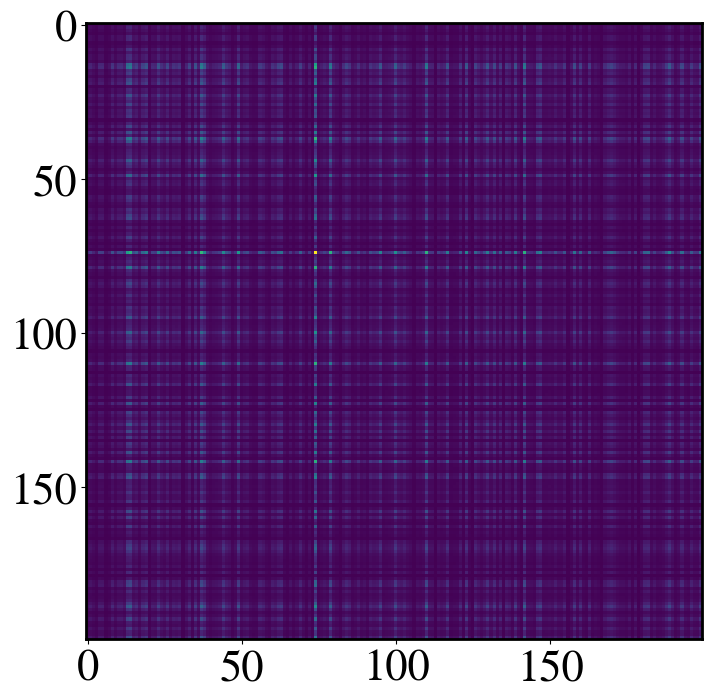

In [104]:
plt.imshow(cov_s)

## Ns

In [105]:
sim_list=['/Users/Hurum/Documents/simulation_new/ns0.8As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/simulation_new/ns0.849As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
          '/Users/Hurum/Documents/simulation_new/ns0.897As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5']

ns_values = [0.8, 0.849, 0.897]


ps_mean=[]

for i in range(0,3):
    lya_file = h5py.File(sim_list[i], 'r')
    all_tau = lya_file['tau']['H']['1']['1215'][:]
    rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.29)),all_tau.shape[1], 10**(-10))

    ## Calculating ST of fid model

    rescaled_tau = rescale_factor*all_tau[:200]
    all_flux = np.exp(-rescaled_tau)
    boxsize = lya_file['Header'].attrs['box']/1000
    z= scale_factor_to_redshift(.29)
    res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
    num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
    coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
    all_flux= coarse_flux
    ps = _powerspectrum(all_flux)
    
    ps_mean.append(ps.mean(axis=1))
    
dcl_dp= [(ps_mean[0]-ps_mean[1])/(ns_values[0]-ns_values[1]),(ps_mean[1]-ps_mean[2])/(ns_values[1]-ns_values[2]),(ps_mean[0]-ps_mean[2])/(ns_values[0]-ns_values[2])]
dcl_dp = np.mean(dcl_dp, axis=0)
inv_diag= np.linalg.inv(cov_s)
ds_dp_cov = np.matmul(inv_diag, dcl_dp)
F_ns_ps= np.matmul(np.transpose(dcl_dp), ds_dp_cov)

print(np.sqrt(1/F_ns_ps))


0.0035196873901101244


## As

In [106]:
sim_list_As=['/Users/Hurum/Documents/simulation_new/ns0.897As1.2e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
          '/Users/Hurum/Documents/simulation_new/ns0.897As1.55e-09heat_slope-0.3heat_amp0.9hub0.7 /lya_forest_spectra.hdf5',
            '/Users/Hurum/Documents/simulation_new/ns0.897As2.25e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5']



As_values = [1.2e-09, 1.55e-09, 2.25e-09]



ps_mean=[]

for i in range(0,3):
    lya_file = h5py.File(sim_list_As[i], 'r')
    all_tau = lya_file['tau']['H']['1']['1215'][:]
    rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.29)),all_tau.shape[1], 10**(-10))

    ## Calculating ST of fid model

    rescaled_tau = rescale_factor*all_tau[:200]
    all_flux = np.exp(-rescaled_tau)
    boxsize = lya_file['Header'].attrs['box']/1000
    z= scale_factor_to_redshift(.29)
    res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
    num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
    coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
    all_flux= coarse_flux
    ps = _powerspectrum(all_flux)
    
    ps_mean.append(ps.mean(axis=1))
    
dcl_dp= [(ps_mean[0]-ps_mean[1])/(As_values[0]-As_values[1]),(ps_mean[1]-ps_mean[2])/(As_values[1]-As_values[2]),(ps_mean[0]-ps_mean[2])/(As_values[0]-As_values[2])]
dcl_dp = np.mean(dcl_dp, axis=0)
inv_diag= np.linalg.inv(cov_s)
ds_dp_cov = np.matmul(inv_diag, dcl_dp)
F_As_ps= np.matmul(np.transpose(dcl_dp), ds_dp_cov)

print(np.sqrt(1/F_As_ps))

nan


/Users/Hurum/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in sqrt


In [107]:
print(np.sqrt(1/np.abs(F_As_ps)))

1.0334092089154935e-11


## $H_A$

In [108]:
sim_list_Ha=['/Users/Hurum/Documents/simulation_new/ns0.897As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/simulation_new/ns0.897As1.9e-09heat_slope-0.3heat_amp1.4hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/simulation_new/ns0.897As1.9e-09heat_slope-0.3heat_amp0.65hub0.7/lya_forest_spectra.hdf5' ]

Ha_values = [.9, 1.4, .65]

ps_mean=[]

for i in range(0,3):
    lya_file = h5py.File(sim_list_Ha[i], 'r')
    all_tau = lya_file['tau']['H']['1']['1215'][:]
    rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.29)),all_tau.shape[1], 10**(-10))

    ## Calculating ST of fid model

    rescaled_tau = rescale_factor*all_tau[:200]
    all_flux = np.exp(-rescaled_tau)
    boxsize = lya_file['Header'].attrs['box']/1000
    z= scale_factor_to_redshift(.29)
    res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
    num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
    coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
    all_flux= coarse_flux
    ps = _powerspectrum(all_flux)
    
    ps_mean.append(ps.mean(axis=1))
    
dcl_dp= [(ps_mean[0]-ps_mean[1])/(Ha_values[0]-Ha_values[1]),(ps_mean[1]-ps_mean[2])/(Ha_values[1]-Ha_values[2]),(ps_mean[0]-ps_mean[2])/(Ha_values[0]-Ha_values[2])]
dcl_dp = np.mean(dcl_dp, axis=0)
inv_diag= np.linalg.inv(cov_s)
ds_dp_cov = np.matmul(inv_diag, dcl_dp)

F_Ha_ps= np.matmul(np.transpose(dcl_dp), ds_dp_cov)
print(np.sqrt(1/F_Ha_ps))


nan


/Users/Hurum/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in sqrt


In [109]:
print(np.sqrt(1/np.abs(F_Ha_ps)))

0.0296991792431919


## $H_S$

In [110]:
sim_list_Hs=['/Users/Hurum/Documents/simulation_new/ns0.897As1.9e-09heat_slope-0.5heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/simulation_new/ns0.897As1.9e-09heat_slope-0.1heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/simulation_new/ns0.897As1.9e-09heat_slope-0.7heat_amp0.9hub0.7/lya_forest_spectra.hdf5']



Hs_values = [-.5, -.1, -.7]

ps_mean=[]

for i in range(0,3):
    lya_file = h5py.File(sim_list_Hs[i], 'r')
    all_tau = lya_file['tau']['H']['1']['1215'][:]
    rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.29)),all_tau.shape[1], 10**(-10))

    ## Calculating ST of fid model

    rescaled_tau = rescale_factor*all_tau[:200]
    all_flux = np.exp(-rescaled_tau)
    boxsize = lya_file['Header'].attrs['box']/1000
    z= scale_factor_to_redshift(.29)
    res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
    num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
    coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
    all_flux= coarse_flux
    ps = _powerspectrum(all_flux)
    
    ps_mean.append(ps.mean(axis=1))
    
dcl_dp= [(ps_mean[0]-ps_mean[1])/(Hs_values[0]-Hs_values[1]),(ps_mean[1]-ps_mean[2])/(Hs_values[1]-Hs_values[2]),(ps_mean[0]-ps_mean[2])/(Hs_values[0]-Hs_values[2])]
dcl_dp = np.mean(dcl_dp, axis=0)
inv_diag= np.linalg.inv(cov_s)
ds_dp_cov = np.matmul(inv_diag, dcl_dp)
F_Hs_ps= np.matmul(np.transpose(dcl_dp), ds_dp_cov)
print(np.sqrt(1/F_Hs_ps))



nan


/Users/Hurum/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in sqrt


In [113]:
print(np.sqrt(1/np.abs(F_Hs_ps)))

0.005270281269992803


In [29]:
def normalize(arr, t_min, t_max):
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max(arr) - min(arr)
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr


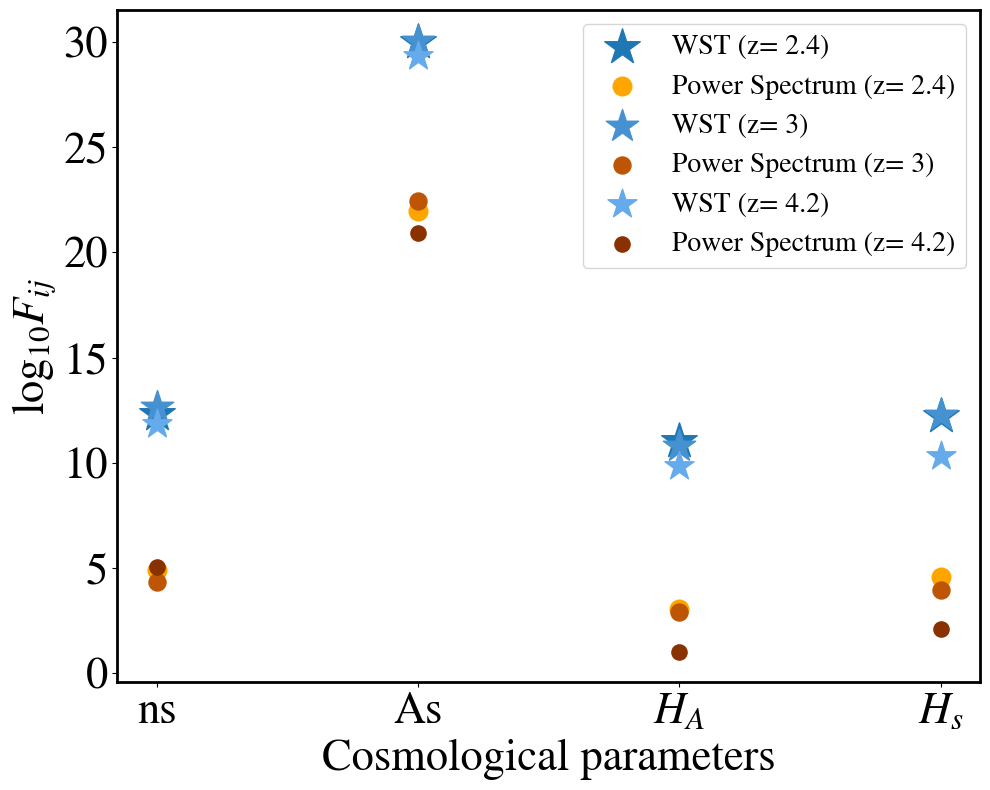

In [184]:
param= ['ns','As',r'$H_A$',r'$H_s$']
plt.scatter(param,np.log10(np.abs([F_ns,F_As, F_Ha, F_Hs])),color='#1f77b4', s= 720, marker= '*', label= 'WST (z= 2.4)')
plt.scatter(param,np.log10(np.abs([F_ns_ps,F_As_ps, F_Ha_ps, F_Hs_ps])) ,marker= '.', color='orange', s= 720, label= 'Power Spectrum (z= 2.4)')

plt.scatter(param,np.log10(np.abs([F_ns_3,F_As_3, F_Ha_3, F_Hs_3])),color='#4691D0',marker= '*', s=600 , label= 'WST (z= 3)')
plt.scatter(param,np.log10(np.abs([F_ns_ps_3,F_As_ps_3, F_Ha_ps_3, F_Hs_ps_3])), marker= '.',  color='#BE5504', s= 600, label= 'Power Spectrum (z= 3)')

plt.scatter(param,np.log10(np.abs([F_ns_4,F_As_4, F_Ha_4, F_Hs_4])),color='#65ABEC', marker= '*' , s= 480 , label= 'WST (z= 4.2)')
plt.scatter(param,np.log10(np.abs([F_ns_ps_4,F_As_ps_4, F_Ha_ps_4, F_Hs_ps_4]))  ,marker= '.', color='#893101', s= 480, label= 'Power Spectrum (z= 4.2)')

plt.xlabel(r'Cosmological parameters')
plt.ylabel(r'$\log_{10}F_{ij}$')
#plt.yscale('log')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('cosmo_par.pdf')
plt.show()

## z=3

In [121]:
L = 6
J = 3
scattering = Scattering2D(J=J, shape=(200, 405), L=L, max_order=2, frontend='numpy')
print(np.shape(scattering))

(200, 405)


In [122]:
num_sims = 2000
st_coeff= []

lya_file = h5py.File('/Users/Hurum/Documents/z=3/ns0.897As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5', 'r')
all_tau = lya_file['tau']['H']['1']['1215'][:]
rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.25)),all_tau.shape[1], 10**(-10))
        
## Calculating ST of fid model

rescaled_tau = rescale_factor*all_tau[:200]
all_flux = np.exp(-rescaled_tau)
boxsize = lya_file['Header'].attrs['box']/1000
z= scale_factor_to_redshift(.25)
res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
all_flux= coarse_flux

#calculating ST of fid model after adding noise
for i in range(0,num_sims):

    
    CNR = np.exp(np.random.normal(0.5323449534337695, 0.36223889354351285, size=all_flux.shape[0]))
    noisy_flux, dn = add_noise(CNR, all_flux)
    

    # Calculating ST fields
    coeffs = scattering(noisy_flux)
    #taking mean over angles and scales
    st = coeffs.mean((-1, -2))
    st_coeff.append(st)
    
    
cov_s= np.cov(np.transpose(st_coeff))
print(np.shape(cov_s))


sim_list=['/Users/Hurum/Documents/z=3/ns0.8As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=3/ns0.849As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
          '/Users/Hurum/Documents/z=3/ns0.897As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5']

ns_values = [0.8, 0.849, 0.897]
st=[]


for i in range(0,3):
    lya_file = h5py.File(sim_list[i], 'r')
    all_tau = lya_file['tau']['H']['1']['1215'][:]
    rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.25)),all_tau.shape[1], 10**(-10))

    ## Calculating ST of fid model

    rescaled_tau = rescale_factor*all_tau[:200]
    all_flux = np.exp(-rescaled_tau)
    boxsize = lya_file['Header'].attrs['box']/1000
    z= scale_factor_to_redshift(.25)
    res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
    num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
    coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
    all_flux= coarse_flux
    
    coeffs = scattering(all_flux)  
    coeffs= coeffs.mean((-1, -2))
    st.append(coeffs)
  
    
dcl_dp= [(st[0]-st[1])/(ns_values[0]-ns_values[1]),(st[1]-st[2])/(ns_values[1]-ns_values[2]),(st[0]-st[2])/(ns_values[0]-ns_values[2])]
dcl_dp = np.mean(dcl_dp, axis=0)
inv_diag= np.linalg.inv(cov_s)
ds_dp_cov = np.matmul(inv_diag, dcl_dp)
F_ns_3= np.matmul(np.transpose(dcl_dp),ds_dp_cov)

sim_list_As=['/Users/Hurum/Documents/z=3/ns0.897As2.25e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=3/ns0.897As1.2e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
          '/Users/Hurum/Documents/z=3/ns0.897As1.55e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5']


As_values = [2.25e-09, 1.2e-09, 1.55e-09]
st=[]


for i in range(0,3):
    lya_file = h5py.File(sim_list_As[i], 'r')
    all_tau = lya_file['tau']['H']['1']['1215'][:]
    rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.25)),all_tau.shape[1], 10**(-10))

    ## Calculating ST of fid model

    rescaled_tau = rescale_factor*all_tau[:200]
    all_flux = np.exp(-rescaled_tau)
    boxsize = lya_file['Header'].attrs['box']/1000
    z= scale_factor_to_redshift(.25)
    res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
    num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
    coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
    all_flux= coarse_flux
    
    coeffs = scattering(all_flux)  
    coeffs= coeffs.mean((-1, -2))
    st.append(coeffs)
  
    
dcl_dp= [(st[0]-st[1])/(As_values[0]-As_values[1]),(st[1]-st[2])/(As_values[1]-As_values[2]),(st[0]-st[2])/(As_values[0]-As_values[2])]
dcl_dp = np.mean(dcl_dp, axis=0)
inv_diag= np.linalg.inv(cov_s)
ds_dp_cov = np.matmul(inv_diag, dcl_dp)
F_As_3= np.matmul(np.transpose(dcl_dp),ds_dp_cov)
print(np.sqrt(1/F_As_3))


sim_list_Hs=['/Users/Hurum/Documents/z=3/ns0.897As1.9e-09heat_slope-0.5heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=3/ns0.897As1.9e-09heat_slope-0.1heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=3/ns0.897As1.9e-09heat_slope-0.7heat_amp0.9hub0.7/lya_forest_spectra.hdf5']

Hs_values = [-.5, -.1, -.7]
st=[]


for i in range(0,3):
    lya_file = h5py.File(sim_list_Hs[i], 'r')
    all_tau = lya_file['tau']['H']['1']['1215'][:]
    rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.25)),all_tau.shape[1], 10**(-10))

    ## Calculating ST of fid model

    rescaled_tau = rescale_factor*all_tau[:200]
    all_flux = np.exp(-rescaled_tau)
    boxsize = lya_file['Header'].attrs['box']/1000
    z= scale_factor_to_redshift(.25)
    res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
    num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
    coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
    all_flux= coarse_flux
    
    coeffs = scattering(all_flux)  
    coeffs= coeffs.mean((-1, -2))
    st.append(coeffs)
  
    
dcl_dp= [(st[0]-st[1])/(Hs_values[0]-Hs_values[1]),(st[1]-st[2])/(Hs_values[1]-Hs_values[2]),(st[0]-st[2])/(Hs_values[0]-Hs_values[2])]
dcl_dp = np.mean(dcl_dp, axis=0)
inv_diag= np.linalg.inv(cov_s)
ds_dp_cov = np.matmul(inv_diag, dcl_dp)
F_Hs_3= np.matmul(np.transpose(dcl_dp),ds_dp_cov)


sim_list_Ha=['/Users/Hurum/Documents/z=3/ns0.897As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=3/ns0.897As1.9e-09heat_slope-0.3heat_amp1.4hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=3/ns0.897As1.9e-09heat_slope-0.3heat_amp0.65hub0.7/lya_forest_spectra.hdf5' ]



Ha_values = [.9, 1.4, .65]
st=[]


for i in range(0,3):
    lya_file = h5py.File(sim_list_Ha[i], 'r')
    all_tau = lya_file['tau']['H']['1']['1215'][:]
    rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.25)),all_tau.shape[1], 10**(-10))

    ## Calculating ST of fid model

    rescaled_tau = rescale_factor*all_tau[:200]
    all_flux = np.exp(-rescaled_tau)
    boxsize = lya_file['Header'].attrs['box']/1000
    z= scale_factor_to_redshift(.25)
    res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
    num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
    coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
    all_flux= coarse_flux
    
    coeffs = scattering(all_flux)  
    coeffs= coeffs.mean((-1, -2))
    st.append(coeffs)
  
    
dcl_dp= [(st[0]-st[1])/(Ha_values[0]-Ha_values[1]),(st[1]-st[2])/(Ha_values[1]-Ha_values[2]),(st[0]-st[2])/(Ha_values[0]-Ha_values[2])]
dcl_dp = np.mean(dcl_dp, axis=0)
inv_diag= np.linalg.inv(cov_s)
ds_dp_cov = np.matmul(inv_diag, dcl_dp)
F_Ha_3= np.matmul(np.transpose(dcl_dp),ds_dp_cov)



num_sims = 2000

ps_mean=[]
#adjusting for mean flux
lya_file = h5py.File('/Users/Hurum/Documents/z=3/ns0.897As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5', 'r')
all_tau = lya_file['tau']['H']['1']['1215'][:]
rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.25)),all_tau.shape[1], 10**(-10))
        
## smoothing the data

rescaled_tau = rescale_factor*all_tau[:200]
all_flux = np.exp(-rescaled_tau)
boxsize = lya_file['Header'].attrs['box']/1000
z= scale_factor_to_redshift(.25)
res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
all_flux= coarse_flux



#calculating power spectra of fid model after adding noise
for i in range(0,num_sims):
    np.random.seed(42)
    CNR = np.exp(np.random.normal(0.5323449534337695, 0.36223889354351285, size=all_flux.shape[0]))
    noisy_flux, dn = add_noise(CNR, all_flux)

    ps = _powerspectrum(noisy_flux)

    #averaging over the k bins in fourier space
    ps_mean.append(ps.mean(axis=1))
    
#calculating covariance
cov_s= np.cov(np.transpose(ps_mean))

sim_list=['/Users/Hurum/Documents/z=3/ns0.8As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=3/ns0.849As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
          '/Users/Hurum/Documents/z=3/ns0.897As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5']

ns_values = [0.8, 0.849, 0.897]


ps_mean=[]

for i in range(0,3):
    lya_file = h5py.File(sim_list[i], 'r')
    all_tau = lya_file['tau']['H']['1']['1215'][:]
    rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.25)),all_tau.shape[1], 10**(-10))

    ## Calculating ST of fid model

    rescaled_tau = rescale_factor*all_tau[:200]
    all_flux = np.exp(-rescaled_tau)
    boxsize = lya_file['Header'].attrs['box']/1000
    z= scale_factor_to_redshift(.25)
    res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
    num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
    coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
    all_flux= coarse_flux
    ps = _powerspectrum(all_flux)
    
    ps_mean.append(ps.mean(axis=1))
    
dcl_dp= [(ps_mean[0]-ps_mean[1])/(ns_values[0]-ns_values[1]),(ps_mean[1]-ps_mean[2])/(ns_values[1]-ns_values[2]),(ps_mean[0]-ps_mean[2])/(ns_values[0]-ns_values[2])]
dcl_dp = np.mean(dcl_dp, axis=0)
inv_diag= np.linalg.inv(cov_s)
ds_dp_cov = np.matmul(inv_diag, dcl_dp)
F_ns_ps_3= np.matmul(np.transpose(dcl_dp), ds_dp_cov)

print(np.sqrt(1/F_ns_ps))

sim_list_As=['/Users/Hurum/Documents/z=3/ns0.897As1.2e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
          '/Users/Hurum/Documents/z=3/ns0.897As1.55e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
            '/Users/Hurum/Documents/z=3/ns0.897As2.25e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5']



As_values = [1.2e-09, 1.55e-09, 2.25e-09]



ps_mean=[]

for i in range(0,3):
    lya_file = h5py.File(sim_list_As[i], 'r')
    all_tau = lya_file['tau']['H']['1']['1215'][:]
    rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.25)),all_tau.shape[1], 10**(-10))

    ## Calculating ST of fid model

    rescaled_tau = rescale_factor*all_tau[:200]
    all_flux = np.exp(-rescaled_tau)
    boxsize = lya_file['Header'].attrs['box']/1000
    z= scale_factor_to_redshift(.25)
    res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
    num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
    coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
    all_flux= coarse_flux
    ps = _powerspectrum(all_flux)
    
    ps_mean.append(ps.mean(axis=1))
    
dcl_dp= [(ps_mean[0]-ps_mean[1])/(As_values[0]-As_values[1]),(ps_mean[1]-ps_mean[2])/(As_values[1]-As_values[2]),(ps_mean[0]-ps_mean[2])/(As_values[0]-As_values[2])]
dcl_dp = np.mean(dcl_dp, axis=0)
inv_diag= np.linalg.inv(cov_s)
ds_dp_cov = np.matmul(inv_diag, dcl_dp)
F_As_ps_3= np.matmul(np.transpose(dcl_dp), ds_dp_cov)

sim_list_Ha=['/Users/Hurum/Documents/z=3/ns0.897As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=3/ns0.897As1.9e-09heat_slope-0.3heat_amp1.4hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=3/ns0.897As1.9e-09heat_slope-0.3heat_amp0.65hub0.7/lya_forest_spectra.hdf5' ]

Ha_values = [.9, 1.4, .65]

ps_mean=[]

for i in range(0,3):
    lya_file = h5py.File(sim_list_Ha[i], 'r')
    all_tau = lya_file['tau']['H']['1']['1215'][:]
    rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.25)),all_tau.shape[1], 10**(-10))

    ## Calculating ST of fid model

    rescaled_tau = rescale_factor*all_tau[:200]
    all_flux = np.exp(-rescaled_tau)
    boxsize = lya_file['Header'].attrs['box']/1000
    z= scale_factor_to_redshift(.25)
    res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
    num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
    coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
    all_flux= coarse_flux
    ps = _powerspectrum(all_flux)
    
    ps_mean.append(ps.mean(axis=1))
    
dcl_dp= [(ps_mean[0]-ps_mean[1])/(Ha_values[0]-Ha_values[1]),(ps_mean[1]-ps_mean[2])/(Ha_values[1]-Ha_values[2]),(ps_mean[0]-ps_mean[2])/(Ha_values[0]-Ha_values[2])]
dcl_dp = np.mean(dcl_dp, axis=0)
inv_diag= np.linalg.inv(cov_s)
ds_dp_cov = np.matmul(inv_diag, dcl_dp)

F_Ha_ps_3= np.matmul(np.transpose(dcl_dp), ds_dp_cov)

sim_list_Hs=['/Users/Hurum/Documents/z=3/ns0.897As1.9e-09heat_slope-0.5heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=3/ns0.897As1.9e-09heat_slope-0.1heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=3/ns0.897As1.9e-09heat_slope-0.7heat_amp0.9hub0.7/lya_forest_spectra.hdf5']



Hs_values = [-.5, -.1, -.7]

ps_mean=[]

for i in range(0,3):
    lya_file = h5py.File(sim_list_Hs[i], 'r')
    all_tau = lya_file['tau']['H']['1']['1215'][:]
    rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.25)),all_tau.shape[1], 10**(-10))

    ## Calculating ST of fid model

    rescaled_tau = rescale_factor*all_tau[:200]
    all_flux = np.exp(-rescaled_tau)
    boxsize = lya_file['Header'].attrs['box']/1000
    z= scale_factor_to_redshift(.25)
    res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
    num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
    coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
    all_flux= coarse_flux
    ps = _powerspectrum(all_flux)
    
    ps_mean.append(ps.mean(axis=1))
    
dcl_dp= [(ps_mean[0]-ps_mean[1])/(Hs_values[0]-Hs_values[1]),(ps_mean[1]-ps_mean[2])/(Hs_values[1]-Hs_values[2]),(ps_mean[0]-ps_mean[2])/(Hs_values[0]-Hs_values[2])]
dcl_dp = np.mean(dcl_dp, axis=0)
inv_diag= np.linalg.inv(cov_s)
ds_dp_cov = np.matmul(inv_diag, dcl_dp)
F_Hs_ps_3= np.matmul(np.transpose(dcl_dp), ds_dp_cov)



(127, 127)


/Users/Hurum/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in sqrt


nan
0.0035196873901101244


# z=4.2

In [128]:
L = 6
J = 3
scattering = Scattering2D(J=J, shape=(200, 456), L=L, max_order=2, frontend='numpy')
print(np.shape(scattering))

(200, 456)


In [129]:
num_sims = 2000
st_coeff= []

lya_file = h5py.File('/Users/Hurum/Documents/z=4/ns0.897As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5', 'r')
all_tau = lya_file['tau']['H']['1']['1215'][:]
rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.192)),all_tau.shape[1], 10**(-10))
        
## Calculating ST of fid model

rescaled_tau = rescale_factor*all_tau[:200]
all_flux = np.exp(-rescaled_tau)
boxsize = lya_file['Header'].attrs['box']/1000
z= scale_factor_to_redshift(.192)
res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
all_flux= coarse_flux

#calculating ST of fid model after adding noise
for i in range(0,num_sims):

    
    CNR = np.exp(np.random.normal(0.5323449534337695, 0.36223889354351285, size=all_flux.shape[0]))
    noisy_flux, dn = add_noise(CNR, all_flux)
    

    # Calculating ST fields
    coeffs = scattering(noisy_flux)
    #taking mean over angles and scales
    st = coeffs.mean((-1, -2))
    st_coeff.append(st)
    
    
cov_s= np.cov(np.transpose(st_coeff))
print(np.shape(cov_s))


sim_list=['/Users/Hurum/Documents/z=4/ns0.8As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=4/ns0.849As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
          '/Users/Hurum/Documents/z=4/ns0.897As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5']

ns_values = [0.8, 0.849, 0.897]
st=[]


for i in range(0,3):
    lya_file = h5py.File(sim_list[i], 'r')
    all_tau = lya_file['tau']['H']['1']['1215'][:]
    rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.192)),all_tau.shape[1], 10**(-10))

    ## Calculating ST of fid model

    rescaled_tau = rescale_factor*all_tau[:200]
    all_flux = np.exp(-rescaled_tau)
    boxsize = lya_file['Header'].attrs['box']/1000
    z= scale_factor_to_redshift(.192)
    res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
    num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
    coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
    all_flux= coarse_flux
    
    coeffs = scattering(all_flux)  
    coeffs= coeffs.mean((-1, -2))
    st.append(coeffs)
  
    
dcl_dp= [(st[0]-st[1])/(ns_values[0]-ns_values[1]),(st[1]-st[2])/(ns_values[1]-ns_values[2]),(st[0]-st[2])/(ns_values[0]-ns_values[2])]
dcl_dp = np.mean(dcl_dp, axis=0)
inv_diag= np.linalg.inv(cov_s)
ds_dp_cov = np.matmul(inv_diag, dcl_dp)
F_ns_4= np.matmul(np.transpose(dcl_dp),ds_dp_cov)

sim_list_As=['/Users/Hurum/Documents/z=4/ns0.897As2.25e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=4/ns0.897As1.2e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
          '/Users/Hurum/Documents/z=4/ns0.897As1.55e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5']


As_values = [2.25e-09, 1.2e-09, 1.55e-09]
st=[]


for i in range(0,3):
    lya_file = h5py.File(sim_list_As[i], 'r')
    all_tau = lya_file['tau']['H']['1']['1215'][:]
    rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.192)),all_tau.shape[1], 10**(-10))

    ## Calculating ST of fid model

    rescaled_tau = rescale_factor*all_tau[:200]
    all_flux = np.exp(-rescaled_tau)
    boxsize = lya_file['Header'].attrs['box']/1000
    z= scale_factor_to_redshift(.192)
    res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
    num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
    coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
    all_flux= coarse_flux
    
    coeffs = scattering(all_flux)  
    coeffs= coeffs.mean((-1, -2))
    st.append(coeffs)
  
    
dcl_dp= [(st[0]-st[1])/(As_values[0]-As_values[1]),(st[1]-st[2])/(As_values[1]-As_values[2]),(st[0]-st[2])/(As_values[0]-As_values[2])]
dcl_dp = np.mean(dcl_dp, axis=0)
inv_diag= np.linalg.inv(cov_s)
ds_dp_cov = np.matmul(inv_diag, dcl_dp)
F_As_4= np.matmul(np.transpose(dcl_dp),ds_dp_cov)
print(np.sqrt(1/F_As_3))


sim_list_Hs=['/Users/Hurum/Documents/z=4/ns0.897As1.9e-09heat_slope-0.5heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=4/ns0.897As1.9e-09heat_slope-0.1heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=4/ns0.897As1.9e-09heat_slope-0.7heat_amp0.9hub0.7/lya_forest_spectra.hdf5']

Hs_values = [-.5, -.1, -.7]
st=[]


for i in range(0,3):
    lya_file = h5py.File(sim_list_Hs[i], 'r')
    all_tau = lya_file['tau']['H']['1']['1215'][:]
    rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.192)),all_tau.shape[1], 10**(-10))

    ## Calculating ST of fid model

    rescaled_tau = rescale_factor*all_tau[:200]
    all_flux = np.exp(-rescaled_tau)
    boxsize = lya_file['Header'].attrs['box']/1000
    z= scale_factor_to_redshift(.192)
    res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
    num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
    coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
    all_flux= coarse_flux
    
    coeffs = scattering(all_flux)  
    coeffs= coeffs.mean((-1, -2))
    st.append(coeffs)
  
    
dcl_dp= [(st[0]-st[1])/(Hs_values[0]-Hs_values[1]),(st[1]-st[2])/(Hs_values[1]-Hs_values[2]),(st[0]-st[2])/(Hs_values[0]-Hs_values[2])]
dcl_dp = np.mean(dcl_dp, axis=0)
inv_diag= np.linalg.inv(cov_s)
ds_dp_cov = np.matmul(inv_diag, dcl_dp)
F_Hs_4= np.matmul(np.transpose(dcl_dp),ds_dp_cov)


sim_list_Ha=['/Users/Hurum/Documents/z=4/ns0.897As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=4/ns0.897As1.9e-09heat_slope-0.3heat_amp1.4hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=4/ns0.897As1.9e-09heat_slope-0.3heat_amp0.65hub0.7/lya_forest_spectra.hdf5' ]



Ha_values = [.9, 1.4, .65]
st=[]


for i in range(0,3):
    lya_file = h5py.File(sim_list_Ha[i], 'r')
    all_tau = lya_file['tau']['H']['1']['1215'][:]
    rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.192)),all_tau.shape[1], 10**(-10))

    ## Calculating ST of fid model

    rescaled_tau = rescale_factor*all_tau[:200]
    all_flux = np.exp(-rescaled_tau)
    boxsize = lya_file['Header'].attrs['box']/1000
    z= scale_factor_to_redshift(.192)
    res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
    num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
    coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
    all_flux= coarse_flux
    
    coeffs = scattering(all_flux)  
    coeffs= coeffs.mean((-1, -2))
    st.append(coeffs)
  
    
dcl_dp= [(st[0]-st[1])/(Ha_values[0]-Ha_values[1]),(st[1]-st[2])/(Ha_values[1]-Ha_values[2]),(st[0]-st[2])/(Ha_values[0]-Ha_values[2])]
dcl_dp = np.mean(dcl_dp, axis=0)
inv_diag= np.linalg.inv(cov_s)
ds_dp_cov = np.matmul(inv_diag, dcl_dp)
F_Ha_4= np.matmul(np.transpose(dcl_dp),ds_dp_cov)



num_sims = 2000

ps_mean=[]
#adjusting for mean flux
lya_file = h5py.File('/Users/Hurum/Documents/z=3/ns0.897As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5', 'r')
all_tau = lya_file['tau']['H']['1']['1215'][:]
rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.192)),all_tau.shape[1], 10**(-10))
        
## smoothing the data

rescaled_tau = rescale_factor*all_tau[:200]
all_flux = np.exp(-rescaled_tau)
boxsize = lya_file['Header'].attrs['box']/1000
z= scale_factor_to_redshift(.192)
res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
all_flux= coarse_flux



#calculating power spectra of fid model after adding noise
for i in range(0,num_sims):
    np.random.seed(42)
    CNR = np.exp(np.random.normal(0.5323449534337695, 0.36223889354351285, size=all_flux.shape[0]))
    noisy_flux, dn = add_noise(CNR, all_flux)

    ps = _powerspectrum(noisy_flux)

    #averaging over the k bins in fourier space
    ps_mean.append(ps.mean(axis=1))
    
#calculating covariance
cov_s= np.cov(np.transpose(ps_mean))

sim_list=['/Users/Hurum/Documents/z=4/ns0.8As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=4/ns0.849As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
          '/Users/Hurum/Documents/z=4/ns0.897As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5']

ns_values = [0.8, 0.849, 0.897]


ps_mean=[]

for i in range(0,3):
    lya_file = h5py.File(sim_list[i], 'r')
    all_tau = lya_file['tau']['H']['1']['1215'][:]
    rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.192)),all_tau.shape[1], 10**(-10))

    ## Calculating ST of fid model

    rescaled_tau = rescale_factor*all_tau[:200]
    all_flux = np.exp(-rescaled_tau)
    boxsize = lya_file['Header'].attrs['box']/1000
    z= scale_factor_to_redshift(.192)
    res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
    num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
    coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
    all_flux= coarse_flux
    ps = _powerspectrum(all_flux)
    
    ps_mean.append(ps.mean(axis=1))
    
dcl_dp= [(ps_mean[0]-ps_mean[1])/(ns_values[0]-ns_values[1]),(ps_mean[1]-ps_mean[2])/(ns_values[1]-ns_values[2]),(ps_mean[0]-ps_mean[2])/(ns_values[0]-ns_values[2])]
dcl_dp = np.mean(dcl_dp, axis=0)
inv_diag= np.linalg.inv(cov_s)
ds_dp_cov = np.matmul(inv_diag, dcl_dp)
F_ns_ps_4= np.matmul(np.transpose(dcl_dp), ds_dp_cov)

print(np.sqrt(1/F_ns_ps))

sim_list_As=['/Users/Hurum/Documents/z=4/ns0.897As1.2e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
          '/Users/Hurum/Documents/z=4/ns0.897As1.55e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
            '/Users/Hurum/Documents/z=4/ns0.897As2.25e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5']



As_values = [1.2e-09, 1.55e-09, 2.25e-09]



ps_mean=[]

for i in range(0,3):
    lya_file = h5py.File(sim_list_As[i], 'r')
    all_tau = lya_file['tau']['H']['1']['1215'][:]
    rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.192)),all_tau.shape[1], 10**(-10))

    ## Calculating ST of fid model

    rescaled_tau = rescale_factor*all_tau[:200]
    all_flux = np.exp(-rescaled_tau)
    boxsize = lya_file['Header'].attrs['box']/1000
    z= scale_factor_to_redshift(.192)
    res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
    num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
    coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
    all_flux= coarse_flux
    ps = _powerspectrum(all_flux)
    
    ps_mean.append(ps.mean(axis=1))
    
dcl_dp= [(ps_mean[0]-ps_mean[1])/(As_values[0]-As_values[1]),(ps_mean[1]-ps_mean[2])/(As_values[1]-As_values[2]),(ps_mean[0]-ps_mean[2])/(As_values[0]-As_values[2])]
dcl_dp = np.mean(dcl_dp, axis=0)
inv_diag= np.linalg.inv(cov_s)
ds_dp_cov = np.matmul(inv_diag, dcl_dp)
F_As_ps_4= np.matmul(np.transpose(dcl_dp), ds_dp_cov)

sim_list_Ha=['/Users/Hurum/Documents/z=4/ns0.897As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=4/ns0.897As1.9e-09heat_slope-0.3heat_amp1.4hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=4/ns0.897As1.9e-09heat_slope-0.3heat_amp0.65hub0.7/lya_forest_spectra.hdf5' ]

Ha_values = [.9, 1.4, .65]

ps_mean=[]

for i in range(0,3):
    lya_file = h5py.File(sim_list_Ha[i], 'r')
    all_tau = lya_file['tau']['H']['1']['1215'][:]
    rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.192)),all_tau.shape[1], 10**(-10))

    ## Calculating ST of fid model

    rescaled_tau = rescale_factor*all_tau[:200]
    all_flux = np.exp(-rescaled_tau)
    boxsize = lya_file['Header'].attrs['box']/1000
    z= scale_factor_to_redshift(.192)
    res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
    num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
    coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
    all_flux= coarse_flux
    ps = _powerspectrum(all_flux)
    
    ps_mean.append(ps.mean(axis=1))
    
dcl_dp= [(ps_mean[0]-ps_mean[1])/(Ha_values[0]-Ha_values[1]),(ps_mean[1]-ps_mean[2])/(Ha_values[1]-Ha_values[2]),(ps_mean[0]-ps_mean[2])/(Ha_values[0]-Ha_values[2])]
dcl_dp = np.mean(dcl_dp, axis=0)
inv_diag= np.linalg.inv(cov_s)
ds_dp_cov = np.matmul(inv_diag, dcl_dp)

F_Ha_ps_4= np.matmul(np.transpose(dcl_dp), ds_dp_cov)

sim_list_Hs=['/Users/Hurum/Documents/z=4/ns0.897As1.9e-09heat_slope-0.5heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=4/ns0.897As1.9e-09heat_slope-0.1heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=4/ns0.897As1.9e-09heat_slope-0.7heat_amp0.9hub0.7/lya_forest_spectra.hdf5']



Hs_values = [-.5, -.1, -.7]

ps_mean=[]

for i in range(0,3):
    lya_file = h5py.File(sim_list_Hs[i], 'r')
    all_tau = lya_file['tau']['H']['1']['1215'][:]
    rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.192)),all_tau.shape[1], 10**(-10))

    ## Calculating ST of fid model

    rescaled_tau = rescale_factor*all_tau[:200]
    all_flux = np.exp(-rescaled_tau)
    boxsize = lya_file['Header'].attrs['box']/1000
    z= scale_factor_to_redshift(.192)
    res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
    num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
    coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
    all_flux= coarse_flux
    ps = _powerspectrum(all_flux)
    
    ps_mean.append(ps.mean(axis=1))
    
dcl_dp= [(ps_mean[0]-ps_mean[1])/(Hs_values[0]-Hs_values[1]),(ps_mean[1]-ps_mean[2])/(Hs_values[1]-Hs_values[2]),(ps_mean[0]-ps_mean[2])/(Hs_values[0]-Hs_values[2])]
dcl_dp = np.mean(dcl_dp, axis=0)
inv_diag= np.linalg.inv(cov_s)
ds_dp_cov = np.matmul(inv_diag, dcl_dp)
F_Hs_ps_4= np.matmul(np.transpose(dcl_dp), ds_dp_cov)

(127, 127)


/Users/Hurum/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in sqrt


nan
0.0035196873901101244


In [37]:
res_st=[]
res_ps=[]
res_list=[80,90,100,110,120,150]

In [38]:
for i in range (0, 6):
    sim_res= res_list[i]

    num_sims = 2000
    st_coeff= []

    lya_file = h5py.File('/Users/Hurum/Documents/simulation_new/ns0.897As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5', 'r')
    all_tau = lya_file['tau']['H']['1']['1215'][:]
    rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.29)),all_tau.shape[1], 10**(-10))

    ## Calculating ST of fid model

    rescaled_tau = rescale_factor*all_tau[:200]
    all_flux = np.exp(-rescaled_tau)
    boxsize = lya_file['Header'].attrs['box']/1000
    z= scale_factor_to_redshift(.29)
    res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
    num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
    coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
    all_flux= coarse_flux

    #calculating ST of fid model after adding noise
    for i in range(0,num_sims):


        CNR = np.exp(np.random.normal(0.5323449534337695, 0.36223889354351285, size=all_flux.shape[0]))
        noisy_flux, dn = add_noise(CNR, all_flux)


        # Calculating ST fields
        coeffs = scattering(noisy_flux)
        #taking mean over angles and scales
        st = coeffs.mean((-1, -2))
        st_coeff.append(st)


    cov_s= np.cov(np.transpose(st_coeff))
    print(np.shape(cov_s))

    sim_list=['/Users/Hurum/Documents/simulation_new/ns0.8As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
    '/Users/Hurum/Documents/simulation_new/ns0.849As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
              '/Users/Hurum/Documents/simulation_new/ns0.897As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5']

    ns_values = [0.8, 0.849, 0.897]
    st=[]


    for i in range(0,3):
        lya_file = h5py.File(sim_list[i], 'r')
        all_tau = lya_file['tau']['H']['1']['1215'][:]
        rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.29)),all_tau.shape[1], 10**(-10))

        ## Calculating ST of fid model

        rescaled_tau = rescale_factor*all_tau[600:800]
        all_flux = np.exp(-rescaled_tau)
        boxsize = lya_file['Header'].attrs['box']/1000
        z= scale_factor_to_redshift(.29)
        res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
        num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
        coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
        all_flux= coarse_flux

        coeffs = scattering(all_flux)  
        coeffs= coeffs.mean((-1, -2))
        st.append(coeffs)


    dcl_dp= [(st[0]-st[1])/(ns_values[0]-ns_values[1]),(st[1]-st[2])/(ns_values[1]-ns_values[2]),(st[0]-st[2])/(ns_values[0]-ns_values[2])]
    dcl_dp = np.mean(dcl_dp, axis=0)
    inv_diag= np.linalg.inv(cov_s)
    ds_dp_cov = np.matmul(inv_diag, dcl_dp)
    F_ns= np.matmul(np.transpose(dcl_dp),ds_dp_cov)

    res_st.append(F_ns)

    ps_mean=[]
    #adjusting for mean flux
    lya_file = h5py.File('/Users/Hurum/Documents/simulation_new/ns0.897As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5', 'r')
    all_tau = lya_file['tau']['H']['1']['1215'][:]
    rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.29)),all_tau.shape[1], 10**(-10))

    ## smoothing the data

    rescaled_tau = rescale_factor*all_tau[:200]
    all_flux = np.exp(-rescaled_tau)
    boxsize = lya_file['Header'].attrs['box']/1000
    z= scale_factor_to_redshift(.29)
    res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
    num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
    coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
    all_flux= coarse_flux



    #calculating power spectra of fid model after adding noise
    for i in range(0,num_sims):
        np.random.seed(42)
        CNR = np.exp(np.random.normal(0.5323449534337695, 0.36223889354351285, size=all_flux.shape[0]))
        noisy_flux, dn = add_noise(CNR, all_flux)

        ps = _powerspectrum(noisy_flux)

        #averaging over the k bins in fourier space
        ps_mean.append(ps.mean(axis=1))

    #calculating covariance
    cov_s= np.cov(np.transpose(ps_mean))

    sim_list=['/Users/Hurum/Documents/simulation_new/ns0.8As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
    '/Users/Hurum/Documents/simulation_new/ns0.849As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
              '/Users/Hurum/Documents/simulation_new/ns0.897As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5']

    ns_values = [0.8, 0.849, 0.897]


    ps_mean=[]

    for i in range(0,3):
        lya_file = h5py.File(sim_list[i], 'r')
        all_tau = lya_file['tau']['H']['1']['1215'][:]
        rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.29)),all_tau.shape[1], 10**(-10))

        ## Calculating ST of fid model

        rescaled_tau = rescale_factor*all_tau[:200]
        all_flux = np.exp(-rescaled_tau)
        boxsize = lya_file['Header'].attrs['box']/1000
        z= scale_factor_to_redshift(.29)
        res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
        num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
        coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
        all_flux= coarse_flux
        ps = _powerspectrum(all_flux)

        ps_mean.append(ps.mean(axis=1))

    dcl_dp= [(ps_mean[0]-ps_mean[1])/(ns_values[0]-ns_values[1]),(ps_mean[1]-ps_mean[2])/(ns_values[1]-ns_values[2]),(ps_mean[0]-ps_mean[2])/(ns_values[0]-ns_values[2])]
    dcl_dp = np.mean(dcl_dp, axis=0)
    inv_diag= np.linalg.inv(cov_s)
    ds_dp_cov = np.matmul(inv_diag, dcl_dp)
    F_ns_ps= np.matmul(np.transpose(dcl_dp), ds_dp_cov)

    res_ps.append(F_ns_ps)





(127, 127)
(127, 127)
(127, 127)
(127, 127)
(127, 127)
(127, 127)


In [80]:
7/3

2.3333333333333335

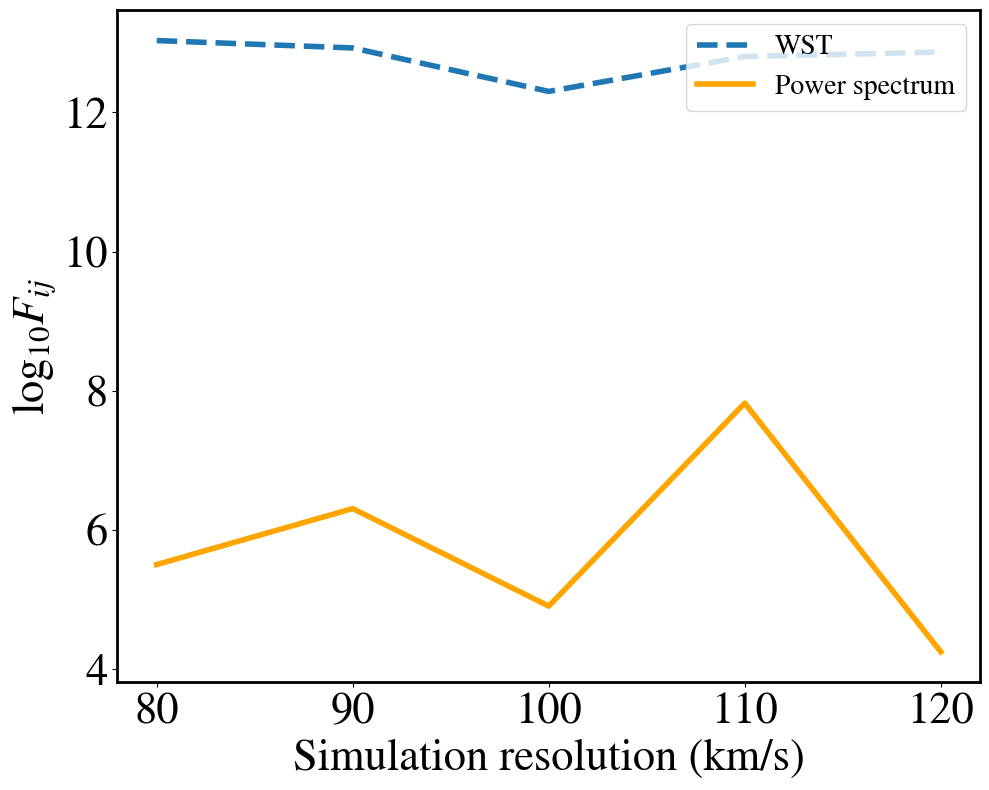

In [90]:

plt.plot(res_list[0:5], np.log10(np.abs(res_st[0:5])), linewidth= 4, linestyle='dashed', label= 'WST')
plt.plot(res_list[0:5], np.log10(np.abs(res_ps[0:5])), linewidth= 4,  linestyle='solid',color='orange', label= 'Power spectrum')
plt.xlabel(r'Simulation resolution (km/s)')
plt.ylabel(r'$\log_{10}F_{ij}$')
#plt.yscale('log')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('res_dependence.pdf')
plt.show()

In [45]:
print(res_ps)

[319001.12475431594, -2034574.5723139634, 80721.9817697462, -66673370.33427597, 17767.259325716906, 198390.22707705374]


In [50]:
print(res_st)

[-10805682010423.463, 8462582124778.331, 2007847029491.329, 6381246540692.797, 7374148047546.0205, -5045223321126.516]


In [83]:
import matplotlib

matplotlib.rcParams['font.family'] = 'Times New Roman'
plt.rcParams["figure.figsize"] = [10.0,8.0]
axislabelfontsize= 54

matplotlib.mathtext.rcParams['legend.fontsize']=20


matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'


plt.rc("axes", linewidth=2.0)
plt.rc("lines", markeredgewidth=3)
plt.rc('axes', labelsize=32)
plt.rc('xtick', labelsize = 32)
plt.rc('ytick', labelsize = 32)

fig_width_pt = 1000 #513.17           # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean=0.9
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]

params = {'backend': 'pdf',
             'axes.labelsize': 54,
             'lines.markersize': 4,
             'font.size': 100,
             'xtick.major.size':6,
             'xtick.minor.size':3,
             'ytick.major.size':6,
             'ytick.minor.size':3,
             'xtick.major.width':0.5,
             'ytick.major.width':0.5,
             'xtick.minor.width':0.5,
             'ytick.minor.width':0.5,
             'lines.markeredgewidth':1,
             'axes.linewidth':1.2,
             'xtick.labelsize': 32,
             'ytick.labelsize': 32,
             'savefig.dpi':2000,
   #      'path.simplify':True,
         'font.family': 'serif',
         'font.serif':'Times',
             'text.usetex':True,
             'text.latex.preamble': [r'\usepackage{amsmath}'],
             'figure.figsize': fig_size}
